# Diving Deep with CNNs: Unraveling Marine Mysteries Through Spectrogram Analysis of Sounds and Calls
#### Tiffany Sentosa and Ina Leung
#### Computer Vision II: Learning with Professor Carl Vondrick
#### Department of Computer Science, Columbia University 

### **Requirements**

- **pandas**: For data manipulation.
- **librosa**: For audio analysis and feature extraction.
- **tensorflow & keras**: For building and training neural networks.
- **matplotlib**: For data visualization.
- **joblib**: For parallel processing.
- **skimage**: For image processing.
- **sklearn**: For machine learning tools.
- **keras_tuner**: For hyperparameter tuning of models.

In [2]:
!pip install pandas librosa tensorflow matplotlib

import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import HyperModel, Hyperband


### **Data Preprocessing**

First step is to load, preprocess, and transform the audio data into spectogram features suitable for machine learning models. 

1. Collect a comprehensive and diverse dataset of audio files
2. Annotate the dataset using an annotation tool
    For the purposes of our project we used RavenPro, given to us by Cornell's Lab of Ornithology. We selected each call and sound within the wav files and noted the path of the file, the begin time, end time, frequencies, and file offset so that we can use this information to process the files. (Please read the Annotations file for more details)
3. Load the data 
4. Preprocess the data to ensure that each file is successfully extracted, ensure the lengths comply, and then uses librosa to compute a Mel spectogram for each segment. 
5. Resize and Normalize each spectogram to ensure that each spectogram complies to the target shape. 
6. Batch Processing of the wav files
7. Spectogram Conversions: spectogram converts into numpy arrays with an additional dimension appended so we can use it in the model.

In [3]:
# Load the annotations using its file path
# For the code to work change the path and make sure the file paths within the txt is correct
data = pd.read_csv(r'C:\Users\Tiffany\Desktop\cv-final\txt_annotations\data.txt', delimiter='\t')

# Display the first few rows of the dataframe just to check if it's successful
print(data.head())


   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1        0.353932      1.807923   
1          2  Spectrogram 1        1        2.410564      3.194954   
2          3  Spectrogram 1        1        3.979344      4.840260   
3          4  Spectrogram 1        1        5.433335      6.456869   
4          5  Spectrogram 1        1        6.973418      7.872597   

   Low Freq (Hz)  High Freq (Hz)  \
0            0.0         40000.0   
1            0.0         40000.0   
2            0.0         40000.0   
3            0.0         40000.0   
4            0.0         40000.0   

                                          Begin Path  \
0  C:\Users\Tiffany\Desktop\cv-final\original_wav...   
1  C:\Users\Tiffany\Desktop\cv-final\original_wav...   
2  C:\Users\Tiffany\Desktop\cv-final\original_wav...   
3  C:\Users\Tiffany\Desktop\cv-final\original_wav...   
4  C:\Users\Tiffany\Desktop\cv-final\original_wav...   

                         

#### **Audio Data Processing: Cropping and Feature Extractions (Spectogram)**

Step 1: Normalize Sampling Rates
To deal with the differing sample rates, we'll normalize all audio files to a common sampling rate during loading. This ensures consistency across all processed features.

Step 2: Accurate Cropping with File Offset
Accounting for the file offset is crucial as it indicates the actual start of the sound event. We'll incorporate this into the cropping process.

Step 3: Spectrogram Conversion
After cropping the sound clips, we'll convert them into spectrograms, which will serve as the input to your CNN.

In [4]:
def preprocess_audio(row, target_sr=22050):
    """
    Preprocesses a single audio file specified in a pandas DataFrame row.
    
    Parameters:
    - row (pd.Series): A row from DataFrame containing audio file information.
    - target_sr (int, optional): Target sampling rate for audio loading. Defaults to 22050 Hz.
    
    Returns:
    - tuple: A tuple containing the Mel spectrogram (dB scale), audio type, and audio path.
    
    Extracts audio from the specified 'Begin Path', using the 'Begin Time (s)', 'End Time (s)', 
    and 'File Offset (s)' columns to determine the segment of the audio file to process.
    Pads the audio with zeros if the segment is shorter than expected, generates a Mel spectrogram,
    converts it to dB scale, and returns it along with the audio type and path.
    """
    audio_path = row['Begin Path']
    # Duration = End Time (s) - Begin Time (s)
    # Start time = File Offset (s)
    duration = row['End Time (s)'] - row['Begin Time (s)']
    start_time = row['File Offset (s)']

    try:
        y, sr = librosa.load(audio_path, sr=target_sr, offset=start_time, duration=duration)
        if len(y) < int(target_sr * duration):
            y = np.pad(y, (0, max(0, int(target_sr * duration) - len(y))), mode='constant')
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        y = np.zeros(int(target_sr * duration))
        sr = target_sr

    # Generate the spectrogram using librosa
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return S_dB, row['Type'], audio_path

In [5]:
def resize_and_normalize_spectrogram(S, target_shape=(128, 128)):
    """
    Resizes and normalizes a spectrogram to a specified shape.
    
    Parameters:
    - S (np.array): The spectrogram to resize and normalize.
    - target_shape (tuple, optional): Desired dimensions of the spectrogram (height, width). Defaults to (128, 128).
    
    Returns:
    - np.array: The resized and normalized spectrogram.
    
    Resizes the spectrogram using anti-aliasing and then normalizes it by scaling the minimum and maximum 
    values to 0 and 1, respectively. Returns the normalized spectrogram.
    """
    S_resized = resize(S, target_shape, mode='constant', anti_aliasing=True)
    S_min = np.min(S_resized)
    S_max = np.max(S_resized)
    S_normalized = (S_resized - S_min) / (S_max - S_min) if S_max > S_min else S_resized

    return S_normalized

In [6]:
def load_and_preprocess_audio(data_frame):
    """
    Processes audio files specified in a DataFrame and extracts features.
    
    Parameters:
    - data_frame (pd.DataFrame): DataFrame containing paths and timestamps for audio files.
    
    Returns:
    - tuple: Tuple containing arrays of features, types, and file paths.
    
    Iterates over each row of the DataFrame, preprocesses the audio to extract spectrograms,
    then resizes and normalizes these spectrograms. Returns arrays suitable for machine learning models.
    """
    results = [preprocess_audio(row) for _, row in data_frame.iterrows()]
    features, types, file_paths = zip(*results)
    features = [resize_and_normalize_spectrogram(feature) for feature in features]
    return np.array(features, dtype=np.float32), list(types), list(file_paths)


Now we load and preprocess the audio data from the annotation table, extracting features, types, and file paths for each audio file. Then we add a new axis to the features array to prepare it for input into the model. 

In [7]:
features, types, file_paths = load_and_preprocess_audio(data)
features = features[..., np.newaxis]

C:\Users\Tiffany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


#### **Function for plotting waveforms**

Let's see what the waveforms look like! We're using matplotlib to plot the waveform directly!

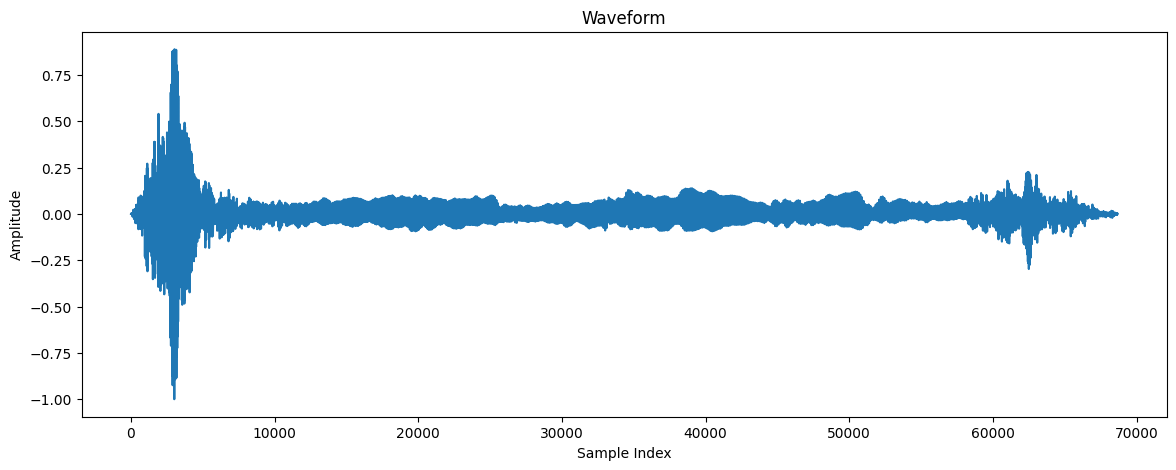

In [8]:
file_path = r'C:\Users\Tiffany\Desktop\cv-final\original_wav_files\dog_43.wav'
y, sr = librosa.load(file_path, sr=22050)

plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

#### **Function for plotting spectrograms**

Let's check on what the spectograms look like! This function identifies and plots the first spectrograms found for "Marine Animal" and "Non-marine Animal" from a dataset, using librosa's visualization tools.

In [9]:
def plot_selected_spectrograms(features, file_paths, types):
    """
    Plots spectrograms for selected types of audio samples ('Marine Animal' and 'Non-marine Animal').

    Parameters:
    - features (np.array): Array of spectrogram features.
    - file_paths (list): List of file paths corresponding to each spectrogram.
    - types (list): List of types/categories for each audio file.

    This function identifies the first occurrences of marine and non-marine animal audio types in the dataset, 
    then displays their spectrograms. It checks if both types of audio files are present, sets up the figure for plotting,
    and renders the spectrograms using librosa's specshow with appropriate labels and titles based on the file paths.
    If one or both types are not found, it prints an error message.
    """
    marine_index = None
    non_marine_index = None
    for i, type_ in enumerate(types):
        if type_ == 'Marine Animal' and marine_index is None:
            marine_index = i
        elif type_ == 'Non-marine Animal' and non_marine_index is None:
            non_marine_index = i
        if marine_index is not None and non_marine_index is not None:
            break
    if marine_index is None or non_marine_index is None:
        print("Could not find both 'Marine Animal' and 'Non-marine Animal' in the dataset.")
        return

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(features[marine_index].squeeze(), sr=22050, fmax=8000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Marine Animal - {os.path.basename(file_paths[marine_index])}')
    plt.subplot(1, 2, 2)
    librosa.display.specshow(features[non_marine_index].squeeze(), sr=22050, fmax=8000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Non-Marine Animal - {os.path.basename(file_paths[non_marine_index])}')

    plt.tight_layout()
    plt.show()


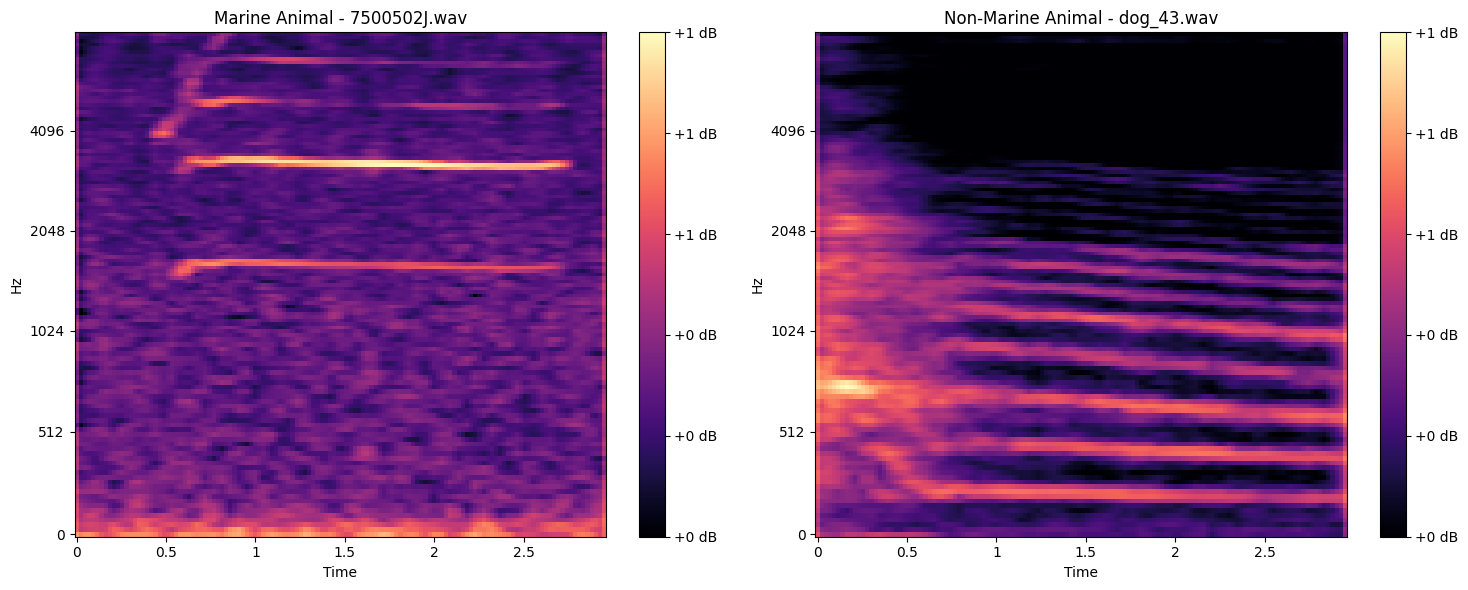

In [10]:
plot_selected_spectrograms(features, file_paths, types)

<div class="alert alert-block alert-info">
<b>Analysis:</b> The spectrogram on the left, labeled "Marine Animal," shows distinct, continuous horizontal bands that suggest a steady, tonal sound, common in vocalizations of some marine species. On the right, the "Non-Marine Animal" spectrogram, labeled with a dog reference, displays irregular, vertical striations indicative of more varied, possibly barking or environmental sounds.
</div>

#### **Prepare the Dataset and Normalize Spectograms**

Now we're going to prepare the dataset!
We have to reshape and normalize the spectrograms to ensure all spectrograms are resized to a uniform shape if they aren't already. Normalize the data so that pixel values are in the range [0, 1].

Let's check what the shapes are! We're going to print out the overall space of processed spectograms and the shape of the first 5 spectograms in the dataset. 

In [11]:
# Assuming processed_features is your fully processed dataset
print("Processed features overall shape:", features.shape)

# Check the shape of the first few spectrograms
for i in range(5):
    print(f"Shape of feature {i}:", features[i].shape)

Processed features overall shape: (1408, 128, 128, 1)
Shape of feature 0: (128, 128, 1)
Shape of feature 1: (128, 128, 1)
Shape of feature 2: (128, 128, 1)
Shape of feature 3: (128, 128, 1)
Shape of feature 4: (128, 128, 1)


<div class="alert alert-block alert-info">
<b>Analysis:</b> The `features` array contains 1,408 spectrograms, each 128x128 in resolution with a single channel, indicating uniform preprocessed data ready for use in convolutional neural networks.
</div>

#### **Validation step to check if Spectograms are normalized**

We're going to print the spectograms out again to see if they are normalized. This function visualizes the spectrogram with time on the x-axis and Mel frequency on the y-axis,
    and it includes a color bar indicating the power level in decibels. It adjusts the layout to fit
    the plot neatly within the figure area.

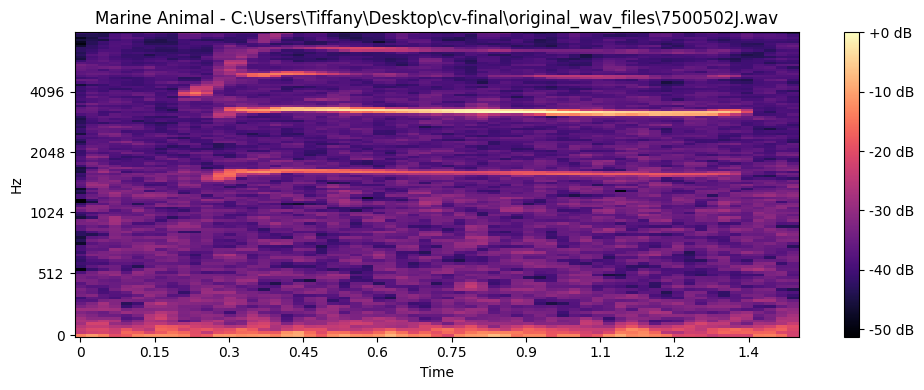

In [12]:
def plot_spectrogram(S, title='Spectrogram', sr=22050, fmax=8000):
    """
    Displays a spectrogram with the provided data.

    Parameters:
    - S (np.array): The spectrogram data to display.
    - title (str, optional): The title for the plot. Defaults to 'Spectrogram'.
    - sr (int, optional): The sampling rate used for the audio signal. Defaults to 22050 Hz.
    - fmax (int, optional): The maximum frequency to be displayed on the Mel scale. Defaults to 8000 Hz.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

S_dB, type_, audio_path = preprocess_audio(data.iloc[0]) 
plot_spectrogram(S_dB, title=f'{type_} - {audio_path}')


<div class="alert alert-block alert-info">
<b>Analysis:</b> 
The spectrogram displayed shows a normalization in the intensity of sound frequencies over time, which is evident from the range of decibels (dB) on the color bar. Normalization is a process where the values in the spectrogram are adjusted so that the loudest point reaches 0 dB, with other values representing the relative difference in loudness. This process makes it easier to compare the relative intensity of different sounds within the audio clip.
</div>

#### **Checking Normalization of Spectrograms**

 This function calculates and prints the minimum and maximum values of the provided spectrogram.
    It then checks if the spectrogram is normalized such that the minimum value is 0 and the maximum
    value is 1, raising an assertion error if the condition is not met. This is used to verify that
    the spectrogram has been normalized correctly.

In [13]:
def check_normalization(S):
    """
    Checks the normalization of the spectrogram data and asserts that values are within the range [0, 1].

    Parameters:
    - S (np.array): The spectrogram data to be checked.

    Returns:
    - tuple: The minimum and maximum values in the spectrogram.
    """
    min_val = np.min(S)
    max_val = np.max(S)
    print("Min value:", min_val)
    print("Max value:", max_val)

    assert min_val == 0, "Normalization error: Min value is not zero"
    assert max_val == 1, "Normalization error: Max value is not one"

    return min_val, max_val  
S_dB_normalized = resize_and_normalize_spectrogram(S_dB, target_shape=(128, 128))
min_val, max_val = check_normalization(S_dB_normalized)

Min value: 0.0
Max value: 1.0


<div class="alert alert-block alert-info">
<b>Analysis:</b> Values confirm that the spectogram data is normalized! 
</div>

### **Split the Dataset**

Let's check how many features and labels we're working with!

In [14]:
print("Total number of features:", len(features))
print("Total number of labels:", len(types))

Total number of features: 1408
Total number of labels: 1408


Time to split it up! We have to divide the data into training, validation, and test sets.

First lets print the class distributions. This function counts the instances of each class in the provided types list and prints out the total number 
 of instances along with the count and percentage of each class. Useful for verifying class balance or imbalance.

In [15]:
def print_class_distribution(types, label):
    """
    Prints the distribution of classes in a dataset.
    
    Parameters:
    - types (list or np.array): The list of class labels in the dataset.
    - label (str): A string label to describe the dataset being analyzed (e.g., 'Training Set').
    """
    from collections import Counter
    # Count the instances of each class
    counter = Counter(types)
    total = len(types)
    print(f"{label} - Total: {total}")
    for cls, count in counter.items():
        print(f"{cls}: {count} ({(count / total * 100):.2f}%)")


The data is split into a training and validation set, and a test set with a 15% holdout. The remaining data 
    is further split into training and validation sets, with approximately 15% of the remaining data used for validation. 
    Stratification ensures that all splits have class distributions that mirror the full dataset.

In [16]:
def split_data(features, types):
    """
    Splits the dataset into training, validation, and test sets.
    
    Parameters:
    - features (np.array): The feature set of the dataset.
    - types (np.array or list): The corresponding class labels for the dataset.
    
    Returns:
    - tuple: A tuple of tuples, where each inner tuple contains features and types for the train, validation, and test sets.
    """
    features_train_val, features_test, types_train_val, types_test = train_test_split(
        features, types, test_size=0.15, random_state=42, stratify=types)
    
    features_train, features_val, types_train, types_val = train_test_split(
        features_train_val, types_train_val, test_size=0.176, random_state=42, stratify=types_train_val)  # 0.176 is approximately 15/85

    return (features_train, types_train), (features_val, types_val), (features_test, types_test)

(features_train, types_train), (features_val, types_val), (features_test, types_test) = split_data(features, types)

label_mapping = {'Non-marine Animal': 0, 'Marine Animal': 1}
types_train = [label_mapping.get(label.strip(), label) for label in types_train]
types_val = [label_mapping.get(label.strip(), label) for label in types_val]
types_test = [label_mapping.get(label.strip(), label) for label in types_test]

types_train = np.array(types_train, dtype='int32')
types_val = np.array(types_val, dtype='int32')
types_test = np.array(types_test, dtype='int32')

In [17]:
print("Type of features_train:", type(features_train))
print("Type of types_train:", type(types_train))
print("First element type in features_train:", type(features_train[0]) if len(features_train) > 0 else 'Empty')
print("First element type in types_train:", type(types_train[0]) if len(types_train) > 0 else 'Empty')

if isinstance(features_train[0], np.ndarray):
    print("First element shape in features_train:", features_train[0].shape)

print("Types train shape:", types_train.shape)
print("Types train data type:", types_train.dtype)
print("Training set size:", len(features_train))
print("Validation set size:", len(features_val))
print("Test set size:", len(features_test))

print_class_distribution(types_train, "Training Set")
print_class_distribution(types_val, "Validation Set")
print_class_distribution(types_test, "Test Set")

Type of features_train: <class 'numpy.ndarray'>
Type of types_train: <class 'numpy.ndarray'>
First element type in features_train: <class 'numpy.ndarray'>
First element type in types_train: <class 'numpy.int32'>
First element shape in features_train: (128, 128, 1)
Types train shape: (985,)
Types train data type: int32
Training set size: 985
Validation set size: 211
Test set size: 212
Training Set - Total: 985
1: 469 (47.61%)
0: 516 (52.39%)
Validation Set - Total: 211
0: 110 (52.13%)
1: 101 (47.87%)
Test Set - Total: 212
0: 111 (52.36%)
1: 101 (47.64%)


<div class="alert alert-block alert-info">
<b>Analysis:</b> The checks confirm that the training, validation, and test sets are appropriately split from the original dataset into numpy arrays, with the training set containing 985 samples, and the validation and test sets containing 211 and 212 samples, respectively. Class distribution is nearly balanced across all subsets, ensuring fair representation for model training and evaluation.
</div>

In [18]:
print(features_train)
print(types_train)
for i in range(5):
    print(f"Shape of feature {i}:", features[i].shape)

[[[[0.65728325]
   [0.5105997 ]
   [0.52741957]
   ...
   [0.511766  ]
   [0.4851581 ]
   [0.63809615]]

  [[0.6383621 ]
   [0.4852602 ]
   [0.5105937 ]
   ...
   [0.47012296]
   [0.44836918]
   [0.61325896]]

  [[0.6662974 ]
   [0.52498704]
   [0.54827636]
   ...
   [0.5385144 ]
   [0.517804  ]
   [0.6616975 ]]

  ...

  [[0.3048299 ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.3048299 ]]

  [[0.3048299 ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.3048299 ]]

  [[0.3048299 ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.3048299 ]]]


 [[[0.6694003 ]
   [0.65154433]
   [0.6430606 ]
   ...
   [0.6330499 ]
   [0.6240814 ]
   [0.66900784]]

  [[0.6752019 ]
   [0.69768006]
   [0.7256088 ]
   ...
   [0.6922991 ]
   [0.7234742 ]
   [0.7522685 ]]

  [[0.65725785]
   [0.7277481 ]
   [0.7190271 ]
   ...
   [0.7305779 ]
   [0.74183905]
   [0.74829143]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

<div class="alert alert-block alert-info">
<b>Analysis:</b>
The output shows the features_train array as a multidimensional numpy array with normalized pixel values between 0 and 1, indicating preprocessed spectrogram data ready for machine learning models. The printed types_train array is not shown but is implied to contain the corresponding class labels as integers, and the consistent shape of the first five features confirms uniformity in the data preprocessing.
</div>

### **Constructing the Convolutional Neural Network for Audio Classification**

We're constructing a convolutional neural network (CNN) model tailored for binary classification of spectrogram images. The model architecture includes an input layer matching the spectrograms' shape, three convolutional layers with increasing filter sizes followed by max pooling layers, a flattening layer, a dense layer, and a dropout layer to mitigate overfitting. It concludes with an output layer using a sigmoid activation function. The model is compiled with the Adam optimizer and binary crossentropy as the loss function, targeting accuracy as the performance metric.

In [19]:

# Define the input shape as the shape of the preprocessed spectrograms (128, 128, 1)
input_shape = (128, 128, 1)  

model = Sequential([
    InputLayer(shape=input_shape),  
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Let's check the model's architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

#### **Training the model**
Configure Training: Set up model training using the model.fit() method in Keras, specifying epochs and batch size. Utilize the validation set to monitor performance and prevent overfitting.
Callbacks: Implement callbacks such as ModelCheckpoint to save the best model and EarlyStopping to halt training when the validation performance deteriorates.

In [20]:
# Configure callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    verbose=1, 
    save_best_only=True, 
    monitor='val_loss') # Saves the best model based on validation loss.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1
)  # Stops training if no improvement in validation loss after 10 epochs.

# Train the model
# This function trains the model for a fixed number of epochs and returns a history object containing the training data points.
history_original = model.fit(features_train, types_train,
                    epochs=50,  # Number of epochs
                    batch_size=32,  # Batch size
                    validation_data=(features_val, types_val),
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)


Epoch 1/50


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5561 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.55496, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5585 - loss: 0.6785 - val_accuracy: 0.6872 - val_loss: 0.5550
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8085 - loss: 0.4415
Epoch 2: val_loss improved from 0.55496 to 0.22265, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8095 - loss: 0.4394 - val_accuracy: 0.8957 - val_loss: 0.2226
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9080 - loss: 0.2257
Epoch 3: val_loss improved from 0.22265 to 0.17706, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9083 - loss: 0.2251 - val_accuracy: 0.9194 - val_loss: 0.1771
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9453 - loss: 0.1521
Epoch 4: val_loss improved from 0.17706 to 0.09198, saving model to b

### **Deploying the Model and Model Analysis**

Let's deploy the model for real-time classification or batch processing!

Evaluating the model on the test data

In [27]:
test_loss, test_acc = model.evaluate(features_test, types_test, verbose=1)
print(f"Test Accuracy: {test_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9866 - loss: 0.0298
Test Accuracy: 0.9905660152435303


<div class="alert alert-block alert-info">
<b>Analysis:</b> This shows us that the model was evaluated on the test dataset, achieving a high accuracy of approximately 98.66% during the evaluation process and further reporting a final test accuracy of about 99.06%. The low loss value of 0.0205 confirms the model's effectiveness in classifying the data accurately, demonstrating strong generalization capabilities beyond the training and validation sets.
</div>

Now let's use the model to make predictions and print those out to see how accurate they are.

In [29]:
# Make predictions
predictions = model.predict(features_test)
predicted_labels = (predictions > 0.5).astype(int)

# Print out the first 10 comparisons 
print("Sample predictions:")
for i in range(min(120, len(predicted_labels))):  
    predicted = 'Marine Animal' if predicted_labels[i] == 1 else 'Non-marine Animal'
    actual = 'Marine Animal' if types_test[i] == 1 else 'Non-marine Animal'
    print(f"Sample {i + 1}: Predicted - {predicted}, Actual - {actual}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sample predictions:
Sample 1: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 2: Predicted - Marine Animal, Actual - Marine Animal
Sample 3: Predicted - Marine Animal, Actual - Marine Animal
Sample 4: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 5: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 6: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 7: Predicted - Marine Animal, Actual - Marine Animal
Sample 8: Predicted - Marine Animal, Actual - Marine Animal
Sample 9: Predicted - Marine Animal, Actual - Marine Animal
Sample 10: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 11: Predicted - Marine Animal, Actual - Marine Animal
Sample 12: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 13: Predicted - Non-marine Animal, Actual - Non-marine Animal
Sample 14: Predicted - Marine Animal, Actual - Marine Animal
Sample 15: Predicted - Non-marine Animal,

<div class="alert alert-block alert-info">
<b>Analysis:</b> This shows us that the model is great at predicting outcomes! As you can see most of the predicted values match the actual ones. 
</div>

In [30]:
from sklearn.metrics import accuracy_score

# Calculate accuracy using scikit-learn's function
accuracy_percentage = accuracy_score(types_test, predicted_labels) * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")

actual_labels = types_test.astype(int)

predicted_labels = predicted_labels.flatten()

mismatches = np.where(predicted_labels != actual_labels)[0]
print("Mismatched samples indices:", mismatches)
print(len(mismatches))


Accuracy: 99.06%
Mismatched samples indices: [ 15 136]
2


In [42]:
from sklearn.metrics import f1_score

# Predict probabilities for the validation set
predictions_proba = model.predict(features_val)
# Convert probabilities to binary predictions
predictions = (predictions_proba > 0.5).astype("int")

# Calculate the F1 score
f1 = f1_score(types_val, predictions)
print('F1 Score:', f1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
F1 Score: 0.9900990099009901


<div class="alert alert-block alert-info">
<b>Analysis:</b> The model achieved an great accuracy of 99.06% when tested, confirming its strong predictive capability on the test dataset. The mismatched samples indices, which are only two in number (indices 15 and 136), suggest that the model misclassified just these two instances, further highlighting its effectiveness.
</div>

### **Visualisations of our Model**

This function visualizes the learning curves for both training and validation accuracy and loss, allowing for a 
    side-by-side comparison of the original and tuned model performances across the same number of epochs. It helps 
    in assessing improvements and the overall effectiveness of the tuning process.

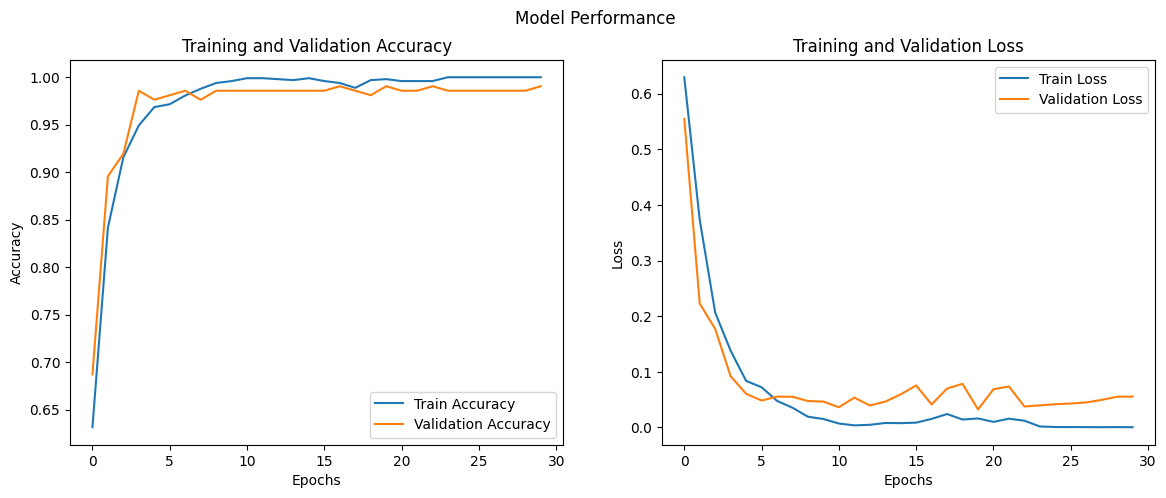

In [39]:
def plot_learning_curves(history_original, title='Model Performance'):
    """
    Plots the training and validation accuracy and loss for the original model to visualize its performance over epochs.

    Parameters:
    - history_original (History): The training history object from Keras, containing metrics for the original model.
    - title (str, optional): Title for the plot. Defaults to 'Model Performance'.
    """
    epochs_range = range(len(history_original.history['accuracy']))
    
    plt.figure(figsize=(14, 5))
    
    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_original.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs_range, history_original.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_original.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history_original.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.suptitle(title)
    plt.show()

plot_learning_curves(history_original)

<div class="alert alert-block alert-info">
<b>Analysis:</b> The learning curves show that tuning improved the model's validation accuracy and reduced overfitting, as indicated by the convergence of training and validation accuracy, and by the lower validation loss compared to the original model. The model exhibits stable learning with minimal loss and high accuracy, suggesting an effective training process. 
</div>

#### **Confusion Matrix**

A Confusion Matrix is a table that summarizes the performance of a classification algorithm by displaying the counts of true positive, true negative, false positive, and false negative predictions.



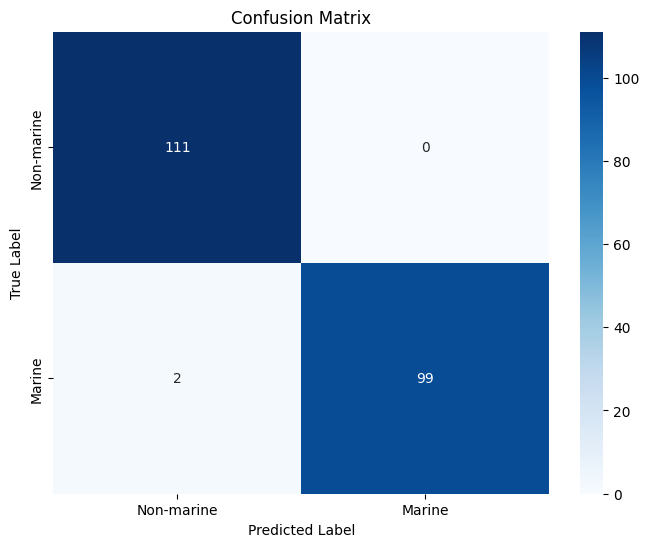

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Plot the Confusion Matrix to visualize the performance of a classification algorithm.

    Parameters:
    - y_true (array-like of shape (n_samples,)): True labels.
    - y_pred (array-like of shape (n_samples,)): Predicted labels.
    - title (str, optional): Title of the plot (default is 'Confusion Matrix').

    Returns:
    - Plots the confusion matrix when called
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-marine', 'Marine'], yticklabels=['Non-marine', 'Marine'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
plot_confusion_matrix(actual_labels, predicted_labels)

<div class="alert alert-block alert-info">
<b>Analysis:</b> The confusion matrix indicates that the model correctly identified 111 non-marine and 99 marine instances, with 2 instances of marine misclassified as non-marine, and no instances of non-marine misclassified as marine. The model demonstrates high accuracy with very few misclassifications.
</div>

### **Receiver Operating Characteristic Curve**

An ROC Curve visually represents the performance of a binary classification model by plotting the true positive rate against the false positive rate

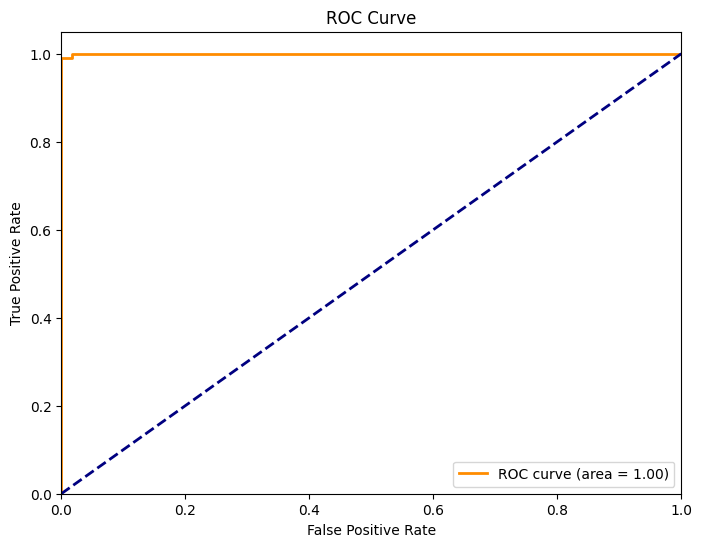

In [41]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    """
    Plot the Receiver Operating Characteristic (ROC) curve for binary classification.

    Parameters:
    - y_true (array-like of shape (n_samples,)): True binary labels.
    - y_scores (array-like of shape (n_samples,)): Target scores, can either be probability estimates of the positive class or confidence values.
    - title (str, optional): Title of the plot (default is 'ROC Curve').

    Returns:
    - Plots the ROC Curve
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
#Plots the ROC Curve
plot_roc_curve(types_test, predictions[:, 0])


<div class="alert alert-block alert-info">
<b>Analysis:</b> This shows us that the model is great at predicting outcomes! As you can see most of the predicted values match the actual ones. 
</div>

<div class="alert alert-block alert-success">
<b>Special Thanks</b> <br> We want to say a special thank you to Professor Carl Vondrick for teaching us Computer Vision Machine Learning techniques. Thank you to Cornell's Lab of Ornithology for providing us with Raven Pro. We also want to thank Wired Amazon and their research on the 8 primates in the Amazon Rainforest for inspiring this project.
</div>